In [1]:
# ==========================================
# Block 1: Imports & Configuration
# ==========================================
import os
import json
import glob
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
from IPython.display import display, Markdown

# --- Magic Command for Inline Plots ---
%matplotlib inline

# --- Academic Plotting Style ---
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman', 'DejaVu Serif']
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.dpi'] = 150  # Display resolution
plt.rcParams['savefig.bbox'] = 'tight'

# --- Configuration ---

# 指标名称映射 (JSON key -> Display Name)
METRIC_MAP = {
    "temp": "Temperature",
    "validation_ppl": "Perplexity (PPL)",
    "fbd_score": "FBD Score",
    "exact_ot_distance": "OT Distance",
    "oracle_entropy": "Oracle Entropy",
    "empirical_bigram_entropy": "Bigram Entropy"
}

print(">>> Environment configured. Ready to load data.")

>>> Environment configured. Ready to load data.


In [2]:
# ==========================================
# Block 2: Data Loading Logic
# ==========================================
def extract_round_number(path):
    """从路径中提取 round 数字"""
    match = re.search(r'round_(\d+)', path)
    if match:
        return int(match.group(1))
    return -1

def load_data():
    files = glob.glob(os.path.join("round_*", "final_results.json"))

    all_data = []
    print(f"Found {len(files)} result files.")
    
    for fpath in files:
        try:
            round_num = extract_round_number(fpath)
            with open(fpath, 'r') as f:
                data = json.load(f)
            # 添加 Round 信息
            for entry in data:
                entry['Round'] = round_num
                all_data.append(entry)
        except Exception as e:
            print(f"Warning: Failed to load {fpath}: {e}")

    df = pd.DataFrame(all_data)
    
    # 重命名列
    rename_dict = {k: v for k, v in METRIC_MAP.items() if k in df.columns}
    df = df.rename(columns=rename_dict)
    
    # 排序
    df = df.sort_values(by=['Round', 'Temperature'])
    return df

# --- Execute Load ---
df = load_data()

if not df.empty:
    display(Markdown(f"### Data Loaded Successfully\nTotal Samples: **{len(df)}**"))
    display(df.head())
else:
    display(Markdown("### ⚠️ No Data Found"))

Found 10 result files.


### Data Loaded Successfully
Total Samples: **100**

,name,Temperature,top_k,top_p,Oracle Entropy,empirical_unigram_entropy,Bigram Entropy,FBD Score,OT Distance,ref_oracle_entropy,ref_bigram_entropy,Perplexity (PPL),Round
10,Temp_0.2,0.2,50,0.95,1.104113,6.367339,9.793251,0.431098,1.067148,3.591097,11.364064,92.106575,1
11,Temp_0.4,0.4,50,0.95,1.307636,6.485941,10.082087,0.430155,1.068975,3.591097,11.364064,58.466049,1
12,Temp_0.6,0.6,50,0.95,1.865125,6.659962,10.532698,0.431146,1.078387,3.591097,11.364064,37.108944,1
13,Temp_0.8,0.8,50,0.95,2.600318,6.859525,11.097908,0.438585,1.091840,3.591097,11.364064,29.447538,1
14,Temp_1.0,1.0,50,0.95,3.036735,7.075149,11.652789,0.442940,1.098141,3.591097,11.364064,26.336838,1


In [3]:
# ==========================================
# Block 3: Statistical Summary (Latest Round)
# ==========================================
def display_styled_table(df):
    if df.empty: return

    max_round = df['Round'].max()
    latest_df = df[df['Round'] == max_round].copy()
    
    cols = ['Temperature', 'Perplexity (PPL)', 'FBD Score', 'OT Distance', 'Oracle Entropy', 'Bigram Entropy']
    # 确保列存在
    cols = [c for c in cols if c in latest_df.columns]
    
    table_df = latest_df[cols].set_index('Temperature')
    
    # 定义格式
    format_dict = {
        'Perplexity (PPL)': "{:.2f}",
        'FBD Score': "{:.2f}",
        'OT Distance': "{:.2f}",
        'Oracle Entropy': "{:.3f}",
        'Bigram Entropy': "{:.3f}"
    }
    
    display(Markdown(f"### 📊 Metrics for Latest Round (Round {max_round})"))
    
    # 使用 Pandas Style 进行美化
    styled = table_df.style.format(format_dict)\
        .background_gradient(cmap='Reds', subset=['Perplexity (PPL)', 'FBD Score', 'OT Distance'])\
        .background_gradient(cmap='Greens', subset=['Oracle Entropy', 'Bigram Entropy'])\
        .set_caption(f"Sensitivity Analysis - Round {max_round}")
        
    display(styled)

# --- Execute ---
display_styled_table(df)

### 📊 Metrics for Latest Round (Round 10)

,Perplexity (PPL),FBD Score,OT Distance,Oracle Entropy,Bigram Entropy
Temperature,,,,,
0.200000,99.68,0.42,1.05,0.843,10.102
0.400000,88.32,0.41,1.05,0.858,10.144
0.600000,73.95,0.41,1.05,0.890,10.193
0.800000,60.30,0.41,1.05,0.947,10.256
1.000000,47.34,0.41,1.06,1.052,10.385
1.200000,38.21,0.41,1.06,1.207,10.521
1.400000,33.28,0.41,1.07,1.474,10.771
1.600000,31.36,0.41,1.07,1.779,11.064
1.800000,30.16,0.41,1.09,2.189,11.502


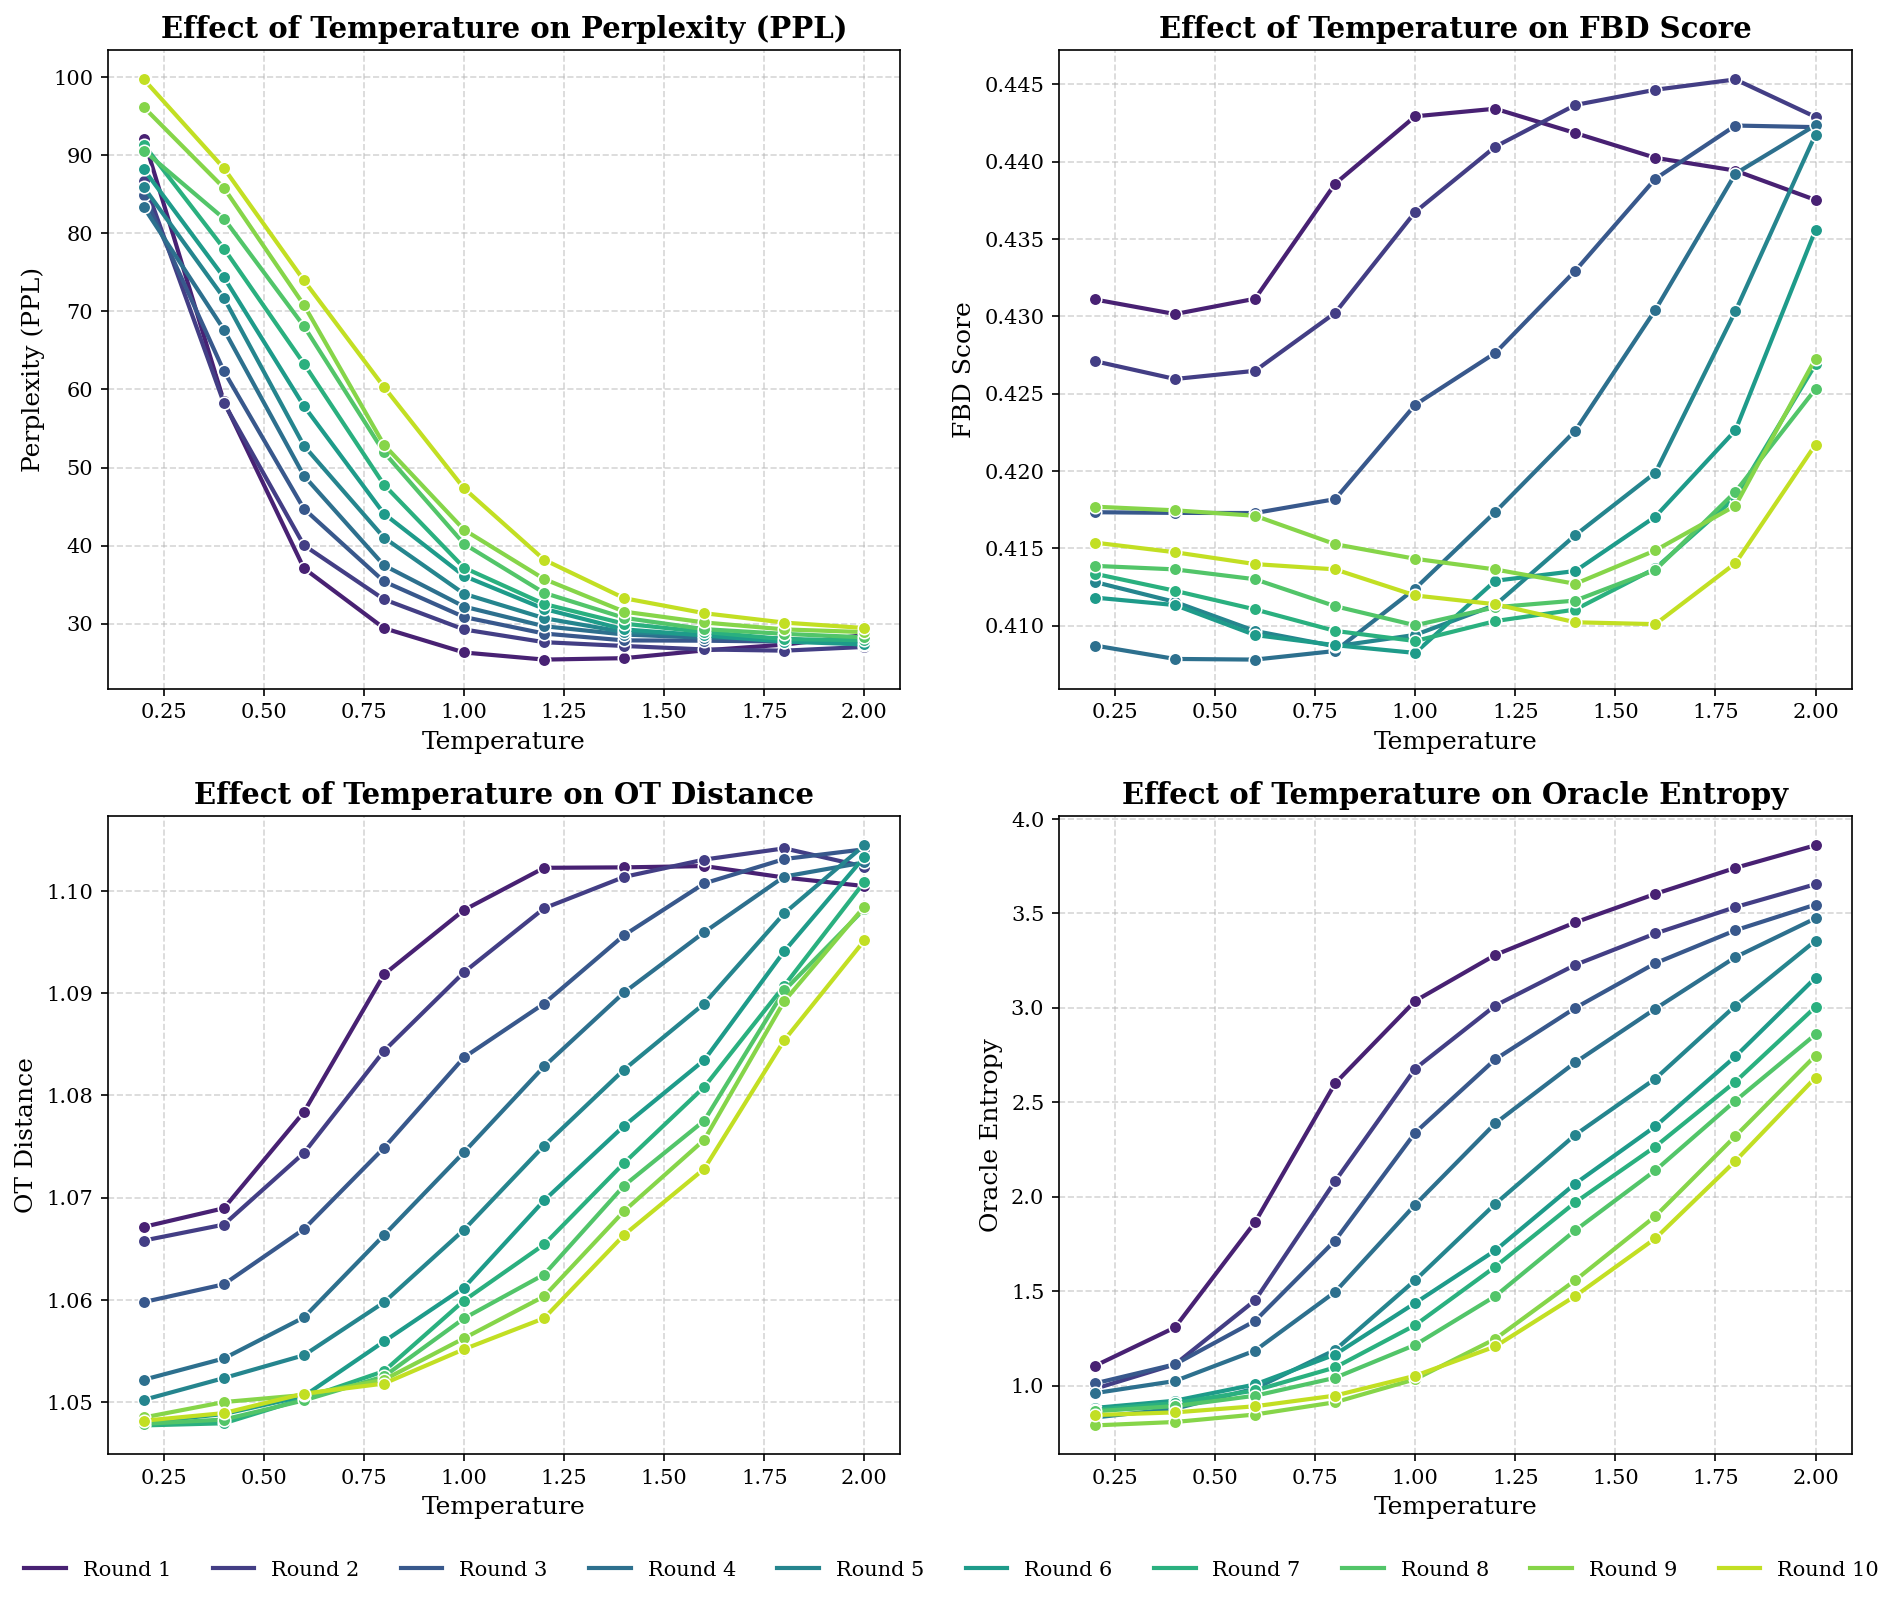

In [4]:
# ==========================================
# Block 4: Trend Analysis (Grid Plot)
# ==========================================
def plot_metrics_grid(df):
    if df.empty: return

    rounds = sorted(df['Round'].unique())
    # 颜色映射：Round 越小颜色越浅
    palette = sns.color_palette("viridis", n_colors=len(rounds))
    
    metrics = ['Perplexity (PPL)', 'FBD Score', 'OT Distance', 'Oracle Entropy']
    metrics = [m for m in metrics if m in df.columns]
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    for i, metric in enumerate(metrics):
        if i >= len(axes): break
        ax = axes[i]
        
        sns.lineplot(
            data=df, 
            x='Temperature', 
            y=metric, 
            hue='Round', 
            palette=palette,
            marker='o',
            markersize=6,
            linewidth=2,
            ax=ax,
            legend=False 
        )
        
        ax.set_title(f"Effect of Temperature on {metric}", fontweight='bold')
        ax.grid(True, linestyle='--', alpha=0.5)

    # 统一图例
    legend_elements = [Line2D([0], [0], color=palette[i], lw=2, label=f'Round {r}') for i, r in enumerate(rounds)]
    fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, 0.02), ncol=min(len(rounds), 10), frameon=False)
    
    plt.subplots_adjust(bottom=0.1)
    plt.show()

# --- Execute ---
plot_metrics_grid(df)

/tmp/ipykernel_2749582/1945738533.py:54: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


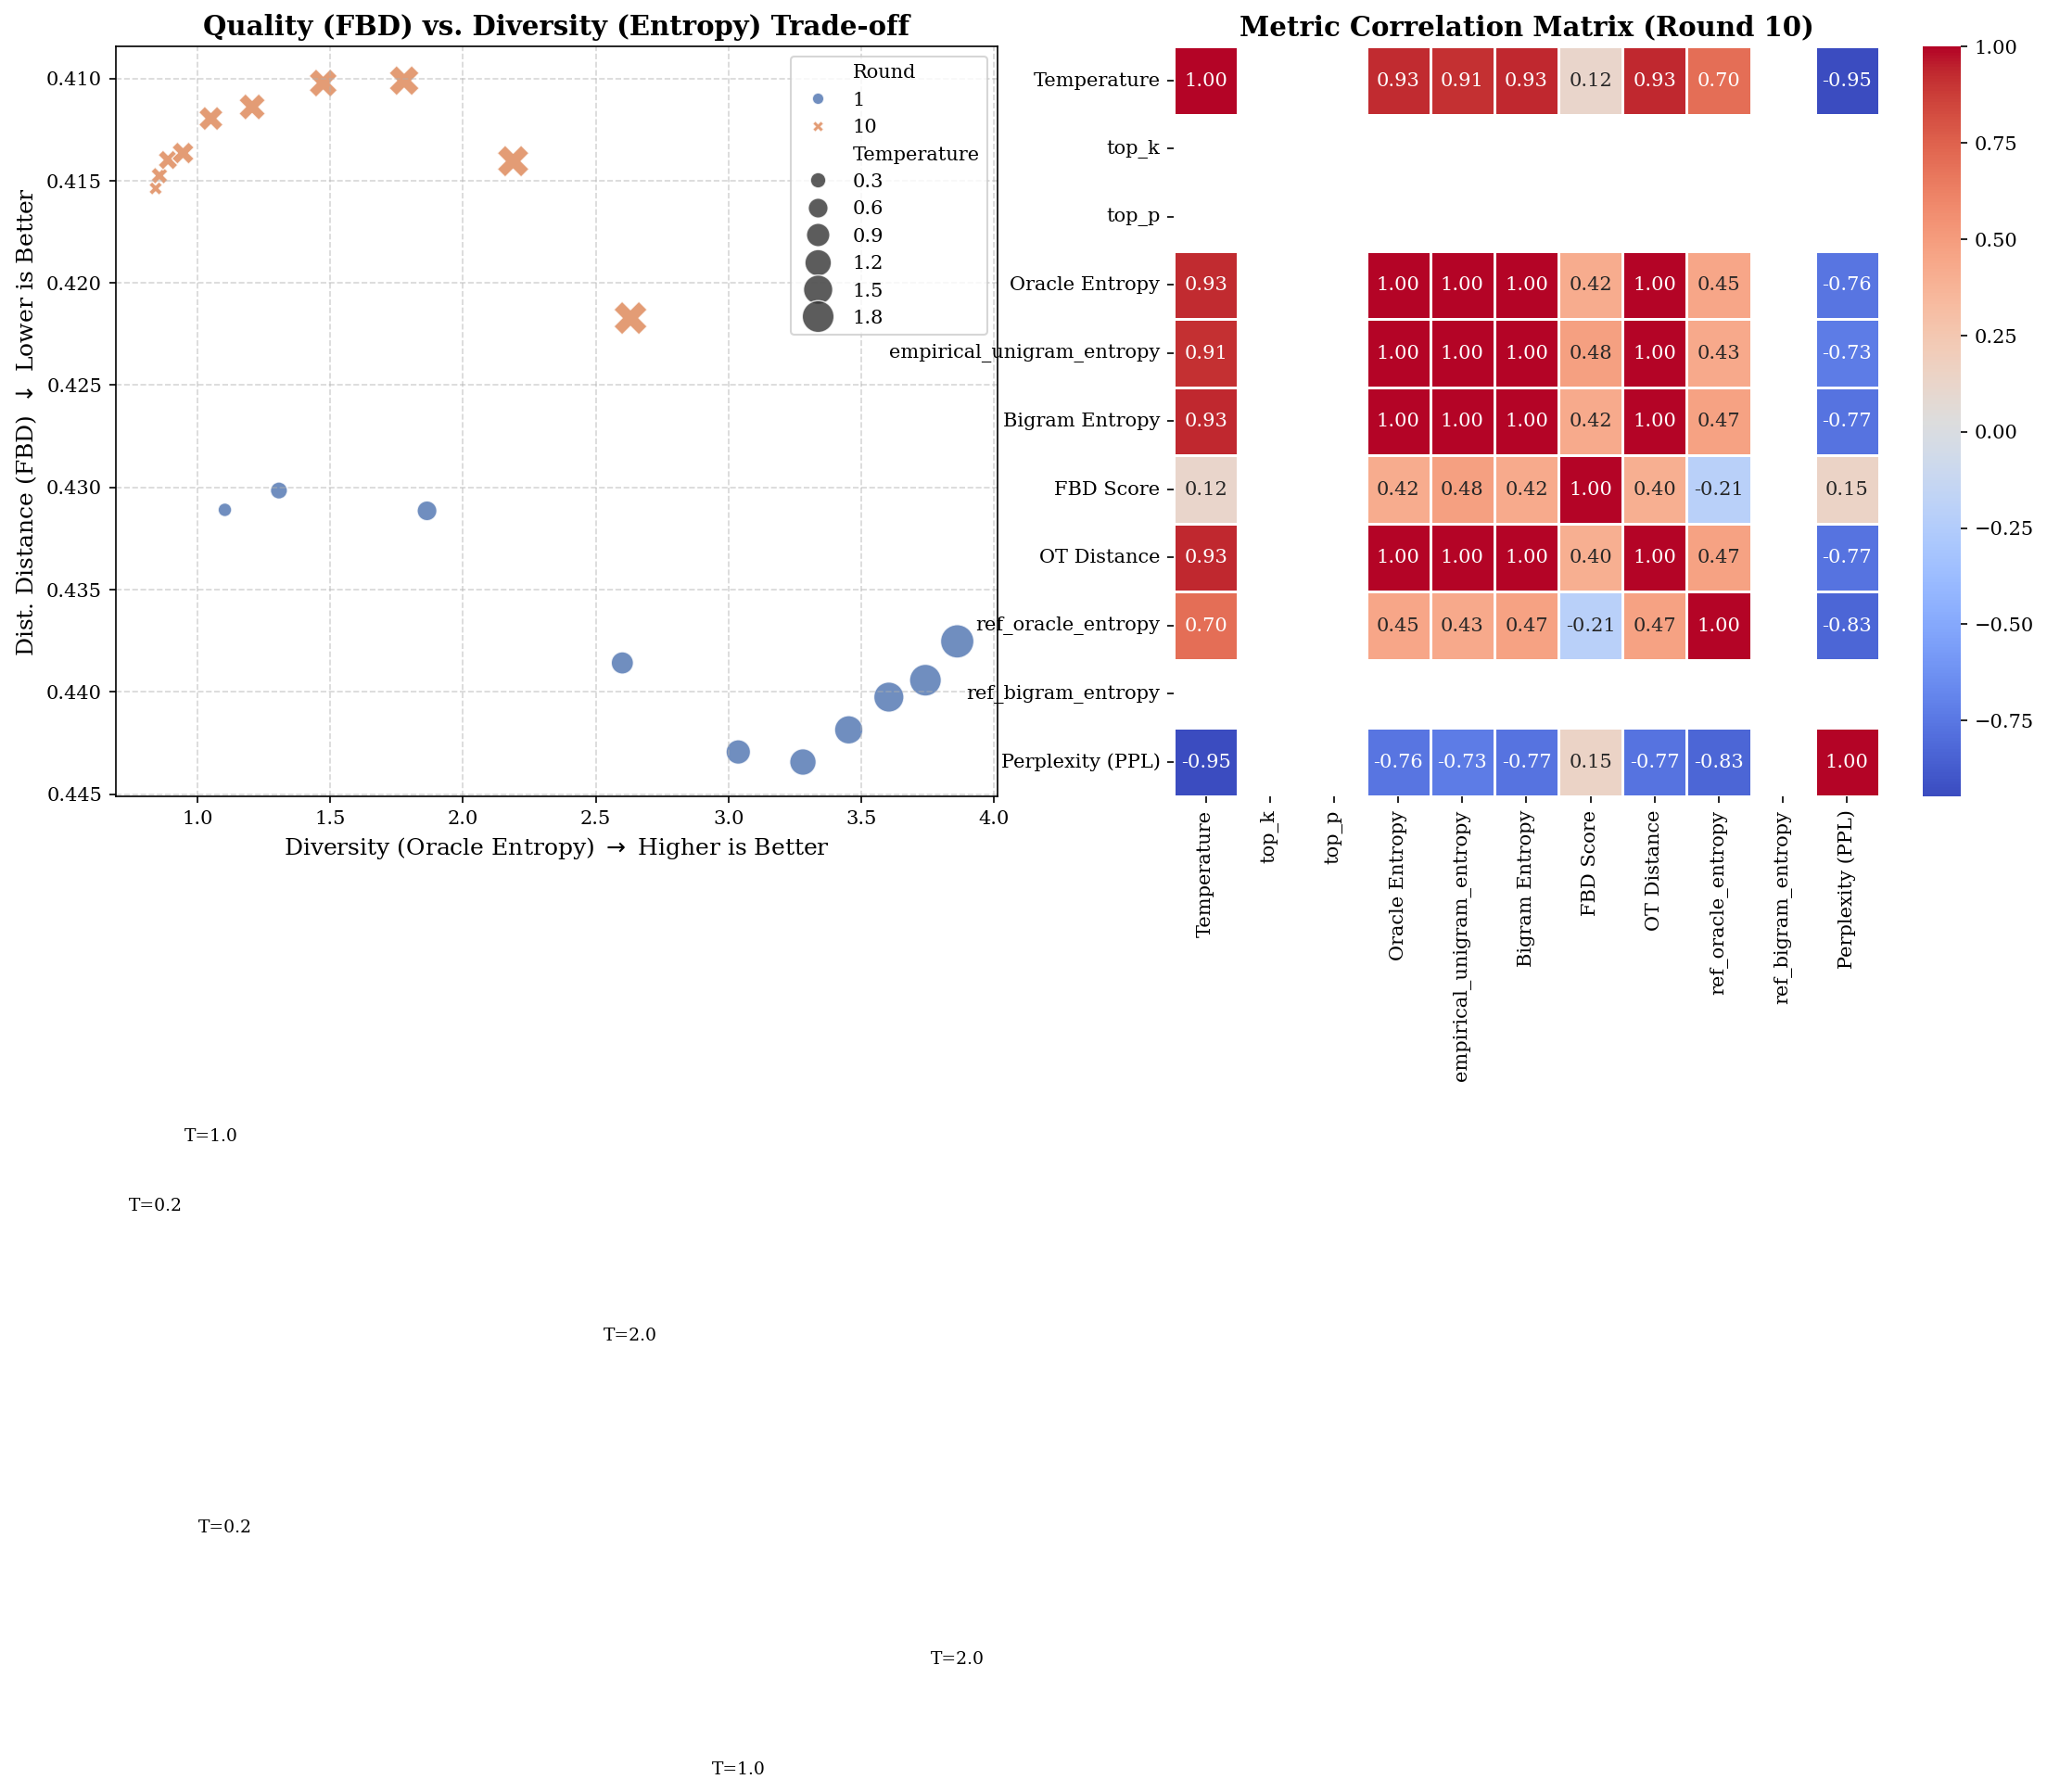

In [6]:
# ==========================================
# Block 5: Trade-off & Correlation Analysis
# ==========================================
def plot_tradeoff_and_heatmap(df):
    if df.empty: return
    
    fig = plt.figure(figsize=(18, 7))
    
    # --- Subplot 1: Trade-off Frontier ---
    ax1 = fig.add_subplot(1, 2, 1)
    rounds = sorted(df['Round'].unique())
    # 对比 Initial vs Final
    target_rounds = [rounds[0], rounds[-1]] if len(rounds) > 1 else rounds
    subset = df[df['Round'].isin(target_rounds)]
    
    sns.scatterplot(
        data=subset,
        x='Oracle Entropy',
        y='FBD Score',
        hue='Round',
        style='Round',
        size='Temperature',
        sizes=(50, 300),
        palette='deep',
        alpha=0.8,
        ax=ax1
    )
    
    # 标注关键 Temperature
    for _, row in subset.iterrows():
        if row['Temperature'] in [0.2, 1.0, 2.0]: 
            ax1.text(
                row['Oracle Entropy'], row['FBD Score'] + 0.05, 
                f"T={row['Temperature']}", ha='center', fontsize=9
            )

    ax1.set_title("Quality (FBD) vs. Diversity (Entropy) Trade-off", fontweight='bold')
    ax1.set_xlabel("Diversity (Oracle Entropy) $\\rightarrow$ Higher is Better")
    ax1.set_ylabel("Dist. Distance (FBD) $\\downarrow$ Lower is Better")
    ax1.invert_yaxis() # 让最好的点 (High Entropy, Low FBD) 位于右上方
    ax1.grid(True, linestyle='--', alpha=0.5)

    # --- Subplot 2: Correlation Heatmap (Latest Round) ---
    ax2 = fig.add_subplot(1, 2, 2)
    max_round = df['Round'].max()
    corr_subset = df[df['Round'] == max_round].select_dtypes(include=['float64', 'int64'])
    
    if 'Round' in corr_subset.columns: del corr_subset['Round']
    
    corr = corr_subset.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, ax=ax2)
    ax2.set_title(f"Metric Correlation Matrix (Round {max_round})", fontweight='bold')

    plt.tight_layout()
    plt.show()

# --- Execute ---
plot_tradeoff_and_heatmap(df)

In [8]:
# ==========================================
# Block 6: Export Data to CSV
# ==========================================
import os

# 定义输出文件名
csv_filename = "analysis_results.csv"

# 组合路径 (默认保存在 sensitivity_analysis 文件夹下，方便归档)
# 如果你想保存在当前目录，可以直接用: save_path = csv_filename
# save_path = os.path.join(RESULT_ROOT, csv_filename)

if not df.empty:
    # index=False 表示不保存 Pandas 自动生成的行索引(0, 1, 2...)
    df.to_csv(csv_filename, index=False, encoding='utf-8-sig')
    
    print(f"✅ 成功导出所有数据！")
    print(f"📂 文件保存路径: {os.path.abspath(csv_filename)}")
    print(f"📊 包含数据条数: {len(df)}")
    print(f"📝 包含字段: {', '.join(df.columns.tolist())}")
else:
    print("⚠️ DataFrame 为空，没有数据可导出。请检查 Block 2 数据加载部分。")

✅ 成功导出所有数据！
📂 文件保存路径: /home/ubuntu/data/simc/gpt2_wikitext2/sensitivity_analysis/analysis_results.csv
📊 包含数据条数: 100
📝 包含字段: name, Temperature, top_k, top_p, Oracle Entropy, empirical_unigram_entropy, Bigram Entropy, FBD Score, OT Distance, ref_oracle_entropy, ref_bigram_entropy, Perplexity (PPL), Round
